In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util_c import NoteIsoSequence
from train_util_c import get_model
from train_util_c import program_map, one_hot_map

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid


In [3]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 44100
sample_duration = 44100
n_fft = 1024
epsilon = 0.00001
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

In [4]:
instr_id = 0
note_id = 0
instrument = pm.instruments[instr_id]
print(instrument.notes[note_id])
note = instrument.notes[note_id]
sample_start = int(note.start * sample_rate)

Note(start=51.199077, end=51.318123, pitch=81, velocity=105)


In [5]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(13841569,)


In [6]:
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(44100,)
0.06190841647480174


(513, 173)
(-3.7645088e-05+0j)


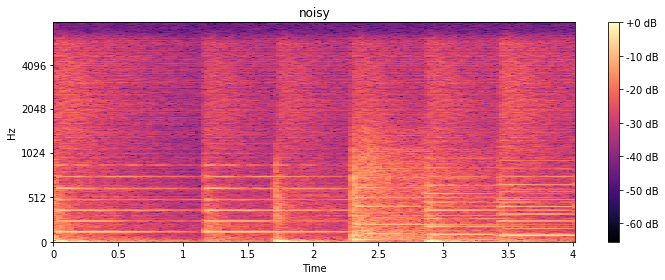

In [7]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
final_noisy = np.stack((noisy_stft.real, noisy_stft.imag), axis=2)
print(final_noisy.shape)

(513, 173, 2)


In [9]:
annotation = np.zeros((1, final_noisy.shape[1], final_noisy.shape[2]))
print(annotation.shape)
annotation[0,0,0] = note.pitch
annotation[0,0,1] = note.end - note.start
final_input = np.append(final_noisy, annotation, axis=0)
print(final_input.shape)

(1, 173, 2)
(514, 173, 2)


In [10]:
pm_iso = pretty_midi.PrettyMIDI()
iso_instrument = pretty_midi.Instrument(instrument.program, is_drum=instrument.is_drum)
iso_note = pretty_midi.Note(note.velocity, note.pitch, 0.0, note.end-note.start)
iso_instrument.notes = [iso_note]
pm_iso.instruments = [iso_instrument]

pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
if len(pm_iso_samples) > sample_duration:
    pm_iso_samples = pm_iso_samples[:sample_duration]
if len(pm_iso_samples) < sample_duration:
    pm_iso_samples = np.pad(pm_iso_samples, (0, sample_duration-len(pm_iso_samples)), 
                            'constant', constant_values=(0,0))

ipd.Audio(pm_iso_samples, rate=sample_rate)

(513, 173)


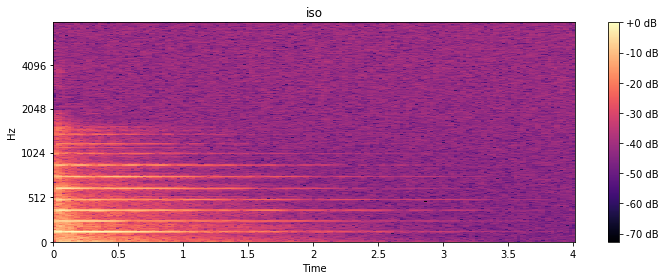

In [11]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

In [12]:
# convert complex numbers to magnitude and phase
magnitude = np.abs(iso_stft)
phase = np.angle(iso_stft)
log_magnitude = np.log(magnitude)
magnitude_scale_factor = max(np.abs(np.amin(log_magnitude)), np.amax(log_magnitude)) + epsilon
scaled_magnitude = log_magnitude / magnitude_scale_factor
print("mag scale factor {}".format(magnitude_scale_factor))
scaled_phase = phase / (np.pi + epsilon)

print("mag unscaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))
print("mag scaled [{}, {}]".format(np.amin(scaled_magnitude), np.amax(scaled_magnitude)))
print("phase unscaled [{}, {}]".format(np.amin(phase), np.amax(phase)))
print("phase scaled [{}, {}]".format(np.amin(scaled_phase), np.amax(scaled_phase)))

final_iso = np.stack((magnitude, phase), axis=2)
print(final_iso.shape)

rev_magnitude = np.exp(scaled_magnitude * magnitude_scale_factor)
assert np.allclose(magnitude, rev_magnitude)
rev_phase = scaled_phase * (np.pi + epsilon)
assert np.allclose(phase, rev_phase)

rev_iso = magnitude * np.exp(1j*phase)
assert iso_stft.shape == rev_iso.shape
assert np.allclose(iso_stft, rev_iso)

# sample_rate = 44100 sample_duration = 44100 n_fft = 1024 -> (513, 173, 2)
# trim axis 1 and pad axis 2 to get 512 (2^9), 175 (5*5*7)
final_iso = final_iso[:-1, :, :]  # shape (512, 173, 2)
print(final_iso.shape)
final_iso_pad = np.zeros((512, 2, 2))
final_iso = np.concatenate((final_iso, final_iso_pad), axis=1)  # shape (512, 175, 2)
print(final_iso.shape)

mag scale factor 12.205664144287109
mag unscaled [5.00209489473491e-06, 93.28759002685547]
mag scaled [-0.9999992251396179, 0.3716050982475281]
phase unscaled [-3.1415927410125732, 3.1415927410125732]
phase scaled [-0.9999968409538269, 0.9999968409538269]
(513, 173, 2)
(512, 173, 2)
(512, 175, 2)


In [20]:
train_generator = NoteIsoSequence([midi_file], sample_duration=sample_duration, 
                                  fs=sample_rate, n_fft=n_fft, mode='train', batch_size=32,
                                  epsilon=epsilon)
valid_generator = NoteIsoSequence([midi_file], sample_duration=sample_duration, 
                                  fs=sample_rate, n_fft=n_fft, mode='train', batch_size=1, 
                                  epsilon=epsilon, debug=True)

In [21]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 514, 173, 10)      190       
_________________________________________________________________
activation_17 (Activation)   (None, 514, 173, 10)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 514, 173, 10)      692       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 86, 10)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 86, 20)       1820      
_________________________________________________________________
activation_18 (Activation)   (None, 128, 86, 20)       0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 86, 20)       344       
__________

In [22]:
model.fit_generator(generator=train_generator,
                    validation_data=train_generator,
                    use_multiprocessing=False,
                    workers=1, steps_per_epoch=100, epochs=1,
                    validation_steps=1)

Epoch 1/1
100/100 [==============================] - 364s 4s/step - loss: 0.1818 - val_loss: 0.1719


In [23]:
# model = keras.models.load_model('draft-3-c.h')

In [24]:
instr_indices = [instr_id]
note_indices = [note_id]
test_generator = NoteIsoSequence([midi_file], sample_duration=sample_duration, 
                                 fs=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
                                 note_indices=note_indices, mode='test')
predicted_iso = model.predict_generator(test_generator, steps=1)[0]
print(predicted_iso.shape)

(512, 175, 2)


-0.67994124
0.48259687
0
0


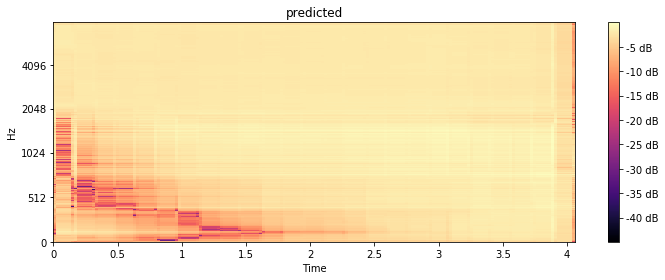

In [25]:
print(np.amin(predicted_iso))
print(np.amax(predicted_iso))
print(np.count_nonzero(np.isnan(predicted_iso)))
print(np.count_nonzero(np.abs(predicted_iso[:,:,1]) == 1))
predicted_iso *= 1 - epsilon
predicted_magnitude = np.exp(predicted_iso[:,:,0] * magnitude_scale_factor)
predicted_phase = predicted_iso[:,:,1] * (np.pi + epsilon)
predicted_stft = predicted_iso[:,:,0] * np.exp(1j*predicted_iso[:,:,1])

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(predicted_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('predicted')
plt.tight_layout()

In [26]:
predicted_audio = librosa.core.istft(predicted_stft)
ipd.Audio(predicted_audio, rate=sample_rate)